# Customer Behaviour Analysis and Segmentation

Customers are one of the most valuable assets for a company's success, but **it is not feasible to manage all customers in the same way**. Effective customer targeting requires segmenting them to build meaningful relationships that surpass their expectations. Since no market offering can cater to every market or individual, segmentation becomes a vital tool in marketing strategies. (Carneiro et al., 2021)

The RFM model is one of the most commonly used segmentation techniques, relying on three metrics: *Recency*, *Frequency*, and *Monetary* value. These metrics are combined into a three-digit RFM cell code, typically divided into five equal quintiles (20% groups). Among these measures, recency is often considered the most significant, but it depends on the company and type of data. RFM are behavioral variables, meaning they are composed of attitudes of customers towards products, unlike demographic or psychographic variables. (Wei et al., 2010)

Wei et al. (2010) suggests the following definitions and encoding practice for Recency, Frequency, and Monetary value:    

- **Recency**: This measures the time elapsed since a customer's last transaction, typically calculated as the number of days or months between the most recent purchase and the analysis date. Customers with more recent purchases receive higher recency scores, indicating greater engagement.  
- **Frequency**: This metric represents the number of purchases a customer has made within a specified time frame. Customers are often categorized based on single or repeated purchases, with higher scores given to those with more frequent transactions.  
- **Monetary**: This evaluates the total amount of money spent by a customer during a defined period. It can be calculated as the total dollar value of all purchases, the average amount spent per purchase, or the cumulative spending to date.  

## Data Exploration and Preprocessing

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from datetime import datetime

import plotly.express as px

In [59]:
df = pd.read_excel('online_retail_II.xlsx')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


### Data Dictionary

**InvoiceNo**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.  

**StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.  

**Description**: Product (item) name. Nominal.  

**Quantity**: The quantities of each product (item) per transaction. Numeric.   

**InvoiceDate**: Invice date and time. Numeric. The day and time when a transaction was generated.  

**UnitPrice**: Unit price. Numeric. Product price per unit in sterling (Â£).  

**CustomerID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.  

**Country**: Country name. Nominal. The name of the country where a customer resides.  

In [61]:
df.shape

(525461, 8)

In [62]:
# Checking if the dataframe contains any duplicate rows
duplicate_rows = df[df.duplicated()]
duplicate_rows.shape

(6865, 8)

In [63]:
# Checking for null values
df.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [64]:
# Dropping duplicates
# Since there is no way to impute Cutomer ID and Description, dropping the NaN rows
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)
df.shape

(410763, 8)

In [65]:
df['Customer ID'] = df['Customer ID'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 410763 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      410763 non-null  object        
 1   StockCode    410763 non-null  object        
 2   Description  410763 non-null  object        
 3   Quantity     410763 non-null  int64         
 4   InvoiceDate  410763 non-null  datetime64[ns]
 5   Price        410763 non-null  float64       
 6   Customer ID  410763 non-null  object        
 7   Country      410763 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 28.2+ MB


In [66]:
# Top 10 products sold
top_10_desc = df.groupby(['Description'])[['Customer ID']].count().sort_values('Customer ID', ascending = False).head(10).reset_index()
top_10_desc = top_10_desc.rename(columns = {'Customer ID': 'Count of Products'})
top_10_desc

,Description,Count of Products
0,WHITE HANGING HEART T-LIGHT HOLDER,3199
1,REGENCY CAKESTAND 3 TIER,1862
2,STRAWBERRY CERAMIC TRINKET BOX,1500
3,ASSORTED COLOUR BIRD ORNAMENT,1362
4,HOME BUILDING BLOCK WORD,1202
5,PACK OF 72 RETRO SPOT CAKE CASES,1193
6,60 TEATIME FAIRY CAKE CASES,1175
7,REX CASH+CARRY JUMBO SHOPPER,1105
8,JUMBO BAG RED RETROSPOT,1105
9,LUNCH BAG RED SPOTTY,1097


Text(0.5, 1.0, 'Top 10 Product Descriptions')

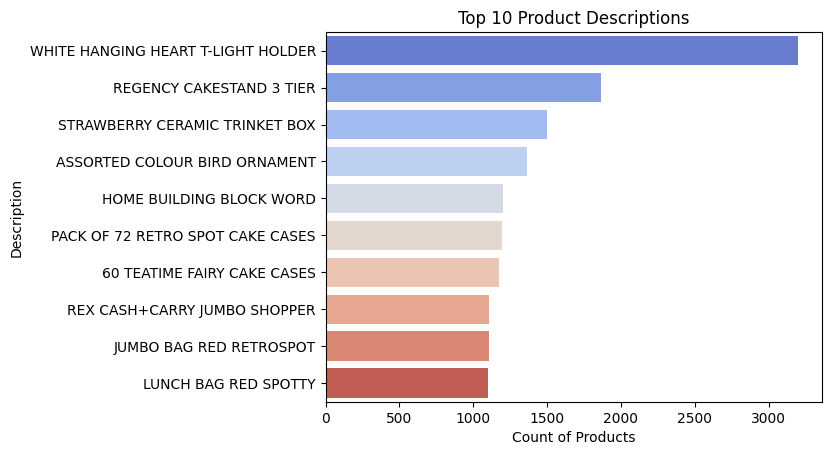

In [67]:
sns.barplot(top_10_desc, x = 'Count of Products', y = 'Description', palette = 'coolwarm')
plt.title('Top 10 Product Descriptions')

It is important to have an idea of total price of the products sold. Therefore, we can create a column "Total Price" which will be the product of quantity and unit price.

In [68]:
df['Total_Price'] = df['Quantity'] * df['Price'] # Creating another column for total price

In [69]:
display(df.sort_values('Price').head())
display(df.sort_values('Price', ascending = False).head())

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price
453705,532470,22624,IVORY KITCHEN SCALES,2,2010-11-12 11:41:00,0.0,12647.0,Germany,0.0
439309,531361,21843,RED RETROSPOT CAKE STAND,2,2010-11-07 14:26:00,0.0,12820.0,United Kingdom,0.0
16107,490727,M,Manual,1,2009-12-07 16:38:00,0.0,17231.0,United Kingdom,0.0
471776,533822,22845,VINTAGE CREAM CAT FOOD CONTAINER,1,2010-11-19 09:40:00,0.0,12647.0,Germany,0.0
149202,503585,22458,CAST IRON HOOK GARDEN FORK,8,2010-04-01 17:13:00,0.0,13047.0,United Kingdom,0.0


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,17399.0,United Kingdom,-25111.09
135012,C502262,M,Manual,-1,2010-03-23 15:20:00,10953.50,12918.0,United Kingdom,-10953.50
135013,502263,M,Manual,1,2010-03-23 15:22:00,10953.50,12918.0,United Kingdom,10953.50
135014,C502264,M,Manual,-1,2010-03-23 15:24:00,10953.50,12918.0,United Kingdom,-10953.50
372833,C525398,M,Manual,-1,2010-10-05 11:47:00,10468.80,14063.0,United Kingdom,-10468.80


From the above output, we can see that there are negative quantities present. This means that returns has been made of the products purchased by customers.

In [70]:
# Making sure that 'Quantity' and 'Price' does not contain any zeros
print("No. of items sold with quantity zero: ", df[df['Quantity'] == 0].count()['Customer ID'])
print("No. of items sold with unit price zero: ", df[df['Price'] == 0].count()['Customer ID'])

No. of items sold with quantity zero:  0
No. of items sold with unit price zero:  31


For products where Price is 0, they must be cancellations.

In [71]:
# Top and bottom 5 most cancelled products
print('Top 5 most cancelled products: \n')
display(df[df['Price'] == 0].sort_values('Quantity', ascending = False).head())
print('Top 5 least cancelled products: \n')
display(df[df['Price'] == 0].sort_values('Quantity', ascending = True).head())

Top 5 most cancelled products: 



,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price
358820,524181,46000M,POLYESTER FILLER PAD 45x45cm,648,2010-09-27 16:59:00,0.0,17450.0,United Kingdom,0.0
392008,527084,22630,DOLLY GIRL LUNCH BOX,64,2010-10-14 15:33:00,0.0,14646.0,Netherlands,0.0
47126,493761,79320,FLAMINGO LIGHTS,24,2010-01-06 14:54:00,0.0,14258.0,United Kingdom,0.0
40101,492760,21143,ANTIQUE GLASS HEART DECORATION,12,2009-12-18 14:22:00,0.0,18071.0,United Kingdom,0.0
57619,494607,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-15 12:43:00,0.0,16858.0,United Kingdom,0.0


Top 5 least cancelled products: 



,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price
166143,505083,22376,AIRLINE BAG VINTAGE JET SET WHITE,1,2010-04-20 09:56:00,0.0,12623.0,Germany,0.0
471775,533822,22846,BREAD BIN DINER STYLE RED,1,2010-11-19 09:40:00,0.0,12647.0,Germany,0.0
400047,527696,22121,NOEL WOODEN BLOCK LETTERS,1,2010-10-18 15:13:00,0.0,13554.0,United Kingdom,0.0
232526,511902,21765,HANGING METAL BIRD BATH,1,2010-06-11 11:12:00,0.0,12748.0,United Kingdom,0.0
471776,533822,22845,VINTAGE CREAM CAT FOOD CONTAINER,1,2010-11-19 09:40:00,0.0,12647.0,Germany,0.0


In [72]:
# Removing cancellations as it won't be useful for further analysis and modelling
df = df[df['Price'] > 0]

Text(0.5, 1.0, 'Top 10 most returned items')

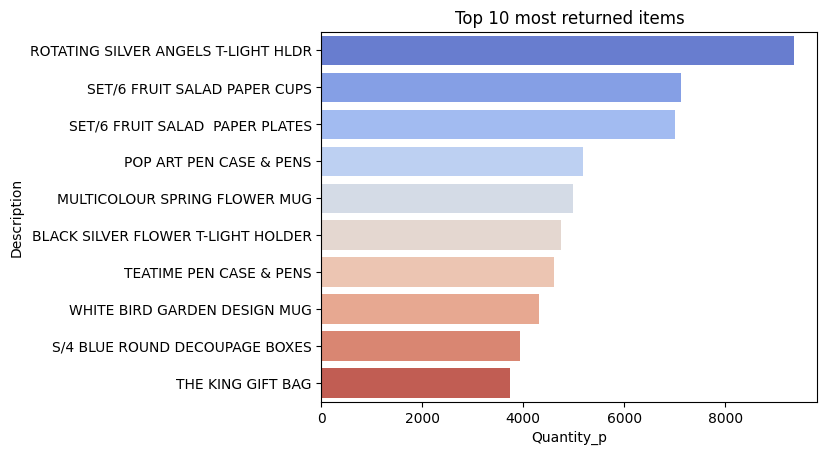

In [73]:
# Top 10 most returned items
top_10_ret = df[df['Quantity'] < 0].sort_values(['Quantity'], ascending = True).head(10)
top_10_ret['Quantity_p'] = -top_10_ret['Quantity'] # To help visualize the total number of returns better
sns.barplot(top_10_ret, x = 'Quantity_p', y = 'Description', palette = 'coolwarm')
plt.title('Top 10 most returned items')

It will be interesting to analyze the returns made by each country and whether it has any relation to the total number of products purchased.

In [74]:
# Most number of returns made from each country
df_retq_by_countries = df[df['Quantity'] < 0].groupby(['Country']).count().sort_values(['Customer ID'], ascending = False)
df_retq_by_countries = df_retq_by_countries.reset_index()
df_retq_by_countries = df_retq_by_countries.drop('Total_Price', axis = 1)
df_retq_by_countries = df_retq_by_countries.rename(columns = {'Customer ID':'No. of Returns'})
df_retp_by_countries = df[df['Quantity'] < 0].groupby(['Country'])[['Total_Price']].sum().sort_values(['Total_Price'], ascending = True)
df_retp_by_countries = df_retp_by_countries.reset_index()
df_retqp_by_countries = df_retq_by_countries.merge(df_retp_by_countries, on = 'Country')[['Country', 'No. of Returns', 'Total_Price']]
df_retqp_by_countries.index = np.arange(1, len(df_retqp_by_countries) + 1) # Setting index such that it starts from 1
df_retqp_by_countries

,Country,No. of Returns,Total_Price
1,United Kingdom,8450,-375850.99
2,Germany,468,-6104.97
3,France,240,-16441.59
4,EIRE,202,-27807.60
5,Channel Islands,85,-3179.00
6,Japan,60,-1286.06
7,Spain,43,-10516.52
8,Portugal,40,-499.77
9,Netherlands,39,-4922.59
10,Australia,24,-1395.00


In [75]:
# No. of orders from each country
df_fulq_by_countries = df[df['Quantity'] > 0].groupby(['Country']).count().sort_values(['Customer ID'], ascending = False)
df_fulq_by_countries = df_fulq_by_countries.reset_index()
df_fulq_by_countries = df_fulq_by_countries.drop('Total_Price', axis = 1)
df_fulq_by_countries = df_fulq_by_countries.rename(columns = {'Customer ID':'No. of Orders Completed'})
df_fulp_by_countries = df[df['Quantity'] > 0].groupby(['Country'])[['Total_Price']].sum().sort_values(['Total_Price'], ascending = False)
df_fulp_by_countries = df_fulp_by_countries.reset_index()
df_fulqp_by_countries = df_fulp_by_countries.merge(df_fulq_by_countries, on = 'Country')[['Country', 'No. of Orders Completed', 'Total_Price']]
df_fulqp_by_countries.index = np.arange(1, len(df_fulqp_by_countries) + 1) # Setting index such that it starts from 1
df_fulqp_by_countries

,Country,No. of Orders Completed,Total_Price
1,United Kingdom,364233,7381644.433
2,EIRE,8503,356041.860
3,Netherlands,2728,268784.350
4,Germany,7645,202025.391
5,France,5452,146107.070
6,Sweden,867,53147.990
7,Denmark,418,50906.850
8,Spain,1228,47568.650
9,Switzerland,1170,43921.390
10,Australia,630,31446.800


In [76]:
df_countries = df_retqp_by_countries.merge(df_fulqp_by_countries, on = 'Country')
df_countries['Net No. of Orders'] = df_countries['No. of Orders Completed'] - df_countries['No. of Returns']
df_countries['Net_Price'] = df_countries['Total_Price_y'] + df_countries['Total_Price_x']
df_countries_disp = df_countries[['Country', 'No. of Orders Completed', 'No. of Returns', 'Net No. of Orders', 'Net_Price']].sort_values(['Net No. of Orders'], ascending = False)
df_countries_disp.index = np.arange(1, len(df_countries_disp) + 1)
df_countries_disp

,Country,No. of Orders Completed,No. of Returns,Net No. of Orders,Net_Price
1,United Kingdom,364233,8450,355783,7005793.443
2,EIRE,8503,202,8301,328234.260
3,Germany,7645,468,7177,195920.421
4,France,5452,240,5212,129665.480
5,Netherlands,2728,39,2689,263861.760
6,Spain,1228,43,1185,37052.130
7,Switzerland,1170,17,1153,43343.410
8,Belgium,1036,16,1020,22644.030
9,Portugal,983,40,943,23343.690
10,Sweden,867,15,852,50836.110


From the above table, it can be seen that most of the orders as well as returns are from European countries, specially United Kingdom, which makes sense because the company is from United Kingdom.

In [77]:
# Removing returns as it won't be useful in further analysis and modelling
df = df[df['Quantity'] > 0]

## Time Series Analysis of Sales

In [78]:
# Time Series Analysis
df['InvoiceDate'].min(), df['InvoiceDate'].max()

(Timestamp('2009-12-01 07:45:00'), Timestamp('2010-12-09 20:01:00'))

In [79]:
# Time period for which we have the data
df['InvoiceDate'].max() - df['InvoiceDate'].min()

Timedelta('373 days 12:16:00')

In [80]:
df['Month_Name'] = df['InvoiceDate'].dt.month_name()
df['Quarter'] = df['InvoiceDate'].dt.quarter
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price,Month_Name,Quarter
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,December,4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,December,4
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,December,4
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,December,4
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,December,4


Text(0.5, 1.0, 'Sales by Quarter')

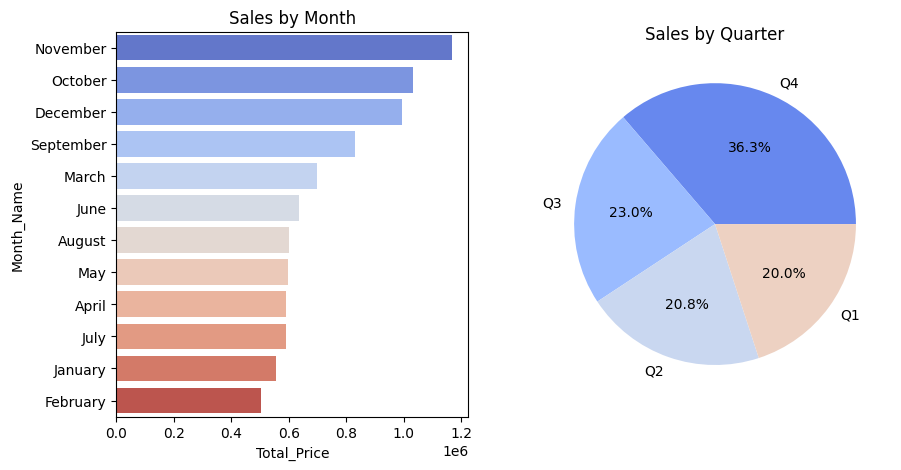

In [81]:
# No. of Sales by month and quarter 
net_sales_month = df.groupby(['Month_Name'])[['Total_Price']].sum().sort_values(['Total_Price'], ascending = False).reset_index()
net_sales_quarter = df.groupby(['Quarter'])[['Total_Price']].sum().sort_values(['Total_Price'], ascending = False).reset_index()
net_sales_quarter
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.barplot(net_sales_month, x = 'Total_Price', y = 'Month_Name', palette = 'coolwarm', ax = ax[0])
ax[0].set_title('Sales by Month')
labels = ['Q4', 'Q3', 'Q2', 'Q1']
ax[1].pie(net_sales_quarter['Total_Price'], labels = labels, colors = sns.color_palette('coolwarm'), autopct='%1.1f%%')
ax[1].set_title('Sales by Quarter')

Text(0.5, 1.0, 'Sales by Month (Line Chart)')

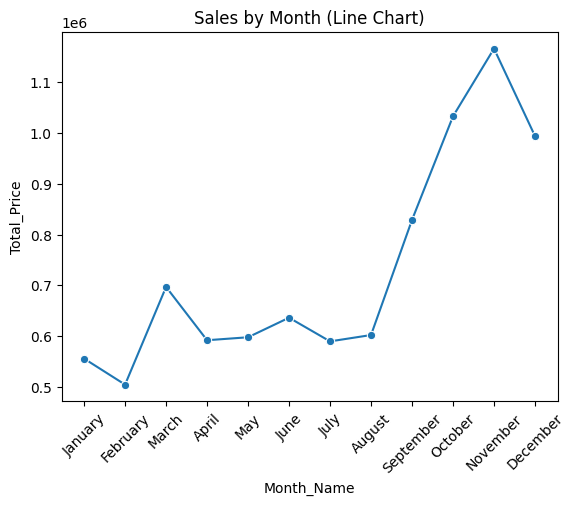

In [82]:
sales_by_month = df[df['Quantity'] > 0].groupby(['Month_Name'])[['Total_Price']].sum().reset_index()
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sales_by_month['Month_Name'] = pd.Categorical(sales_by_month['Month_Name'], months)
sales_by_month = sales_by_month.sort_values(['Month_Name'])
lplot = sns.lineplot(data = sales_by_month, x = 'Month_Name', y = 'Total_Price', marker = 'o')
lplot.set_xticklabels(lplot.get_xticklabels(), rotation = 45)
lplot.set_title('Sales by Month (Line Chart)')

The sales in the first 2 quarters are not that substantial. Sales starts picking up from 3rd quarter and reaching the peak in 4th quarter. 

## RFM Analysis  

For the analysis, we have to set the analysis date which is next to the last date of transaction. Then, we can aggregate the values of Recency, Frequency, and Monetary by Customer ID.

In [83]:
analysis_date = df['InvoiceDate'].max() + pd.DateOffset(1)

rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (analysis_date - x.max()).days,    # Recency
                                    'Invoice': 'nunique',                                        # Frequency
                                    'Total_Price': 'sum'})                                        # Monetary

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


In [84]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4312.0,91.171846,96.860633,1.00,18.0000,53.000,136.0000,374.00
Frequency,4312.0,4.455705,8.170213,1.00,1.0000,2.000,5.0000,205.00
Monetary,4312.0,2040.406712,8911.755977,2.95,307.1875,701.615,1714.9325,349164.35


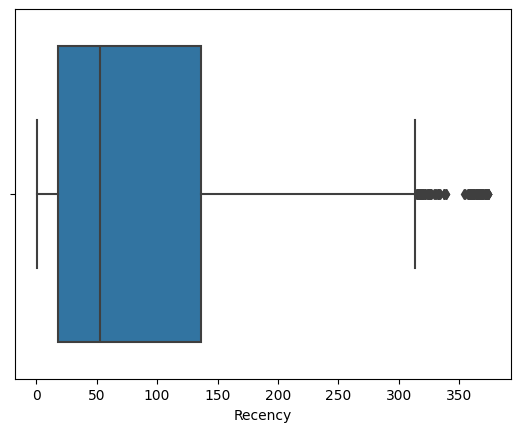

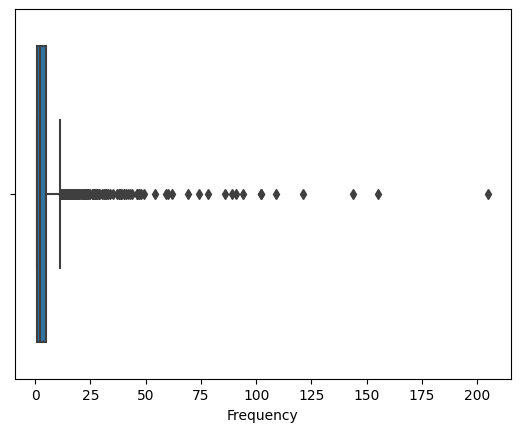

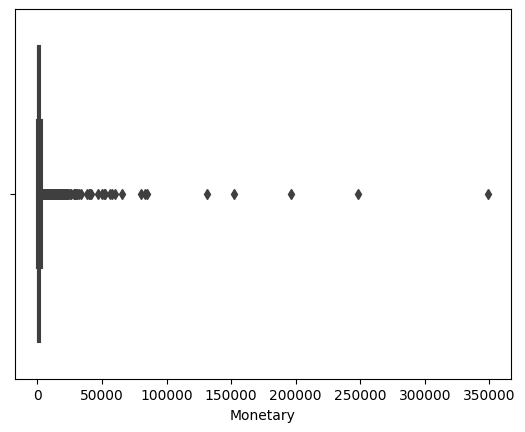

In [85]:
# Checking for outliers
for i in rfm.columns:
    ax = sns.boxplot(x = rfm[i])
    plt.show()

`Recency` has relatively few outliers, and `Monetary` value has the most. Before moving with our model, we will first have to remove the outliers, as k-means clustering is sensitive to outliers. 

In [86]:
# Removing outliers (data points less than or more than 1.5 times IQR minus Q1 and plus Q3)
def rem_outlier(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

for i in rfm.columns:
    rem_outlier(rfm, i)
    print('Outliers removed from: ', i)

Outliers removed from:  Recency
Outliers removed from:  Frequency
Outliers removed from:  Monetary


In [87]:
# Calculating RFM scores
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels = False)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method = 'first'), 5, labels = False)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels = False)

# Low recency score means more recent transaction, meaning recency score of 1 is better than recency score of 5
rfm['R_score'] = 4 - rfm['R_score']
rfm['RFM_score'] = (rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str))
rfm['RFM_score_sum'] = rfm['R_score'] + rfm['F_score'] + rfm['M_score']
rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_score_sum
Customer ID,,,,,,,,
12346.0,165,11,372.86,1,4,1,141,6
12347.0,3,2,1323.32,4,1,3,413,8
12348.0,74,1,222.16,1,0,0,100,1
12349.0,43,3,2671.14,2,2,4,224,8
12351.0,11,1,300.93,4,0,1,401,5


RFM_score_sum values will range from 0 (0 + 0 + 0) to 12 (4 + 4 + 4).

Based on the RFM_score_sum, which is the sum of RFM values, I will segment the customers into three categories, which are:  
- High
- Medium
- Low

In [88]:
def assign_segment(score):
    if ((score >= 1) and (score <= 4)):
        return('Low')
    elif ((score > 4) and (score <= 8)):
        return('Medium')
    else:
        return('High')

rfm['Segment'] = rfm['RFM_score_sum'].apply(assign_segment)
rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_score_sum,Segment
Customer ID,,,,,,,,,
12346.0,165,11,372.86,1,4,1,141,6,Medium
12347.0,3,2,1323.32,4,1,3,413,8,Medium
12348.0,74,1,222.16,1,0,0,100,1,Low
12349.0,43,3,2671.14,2,2,4,224,8,Medium
12351.0,11,1,300.93,4,0,1,401,5,Medium


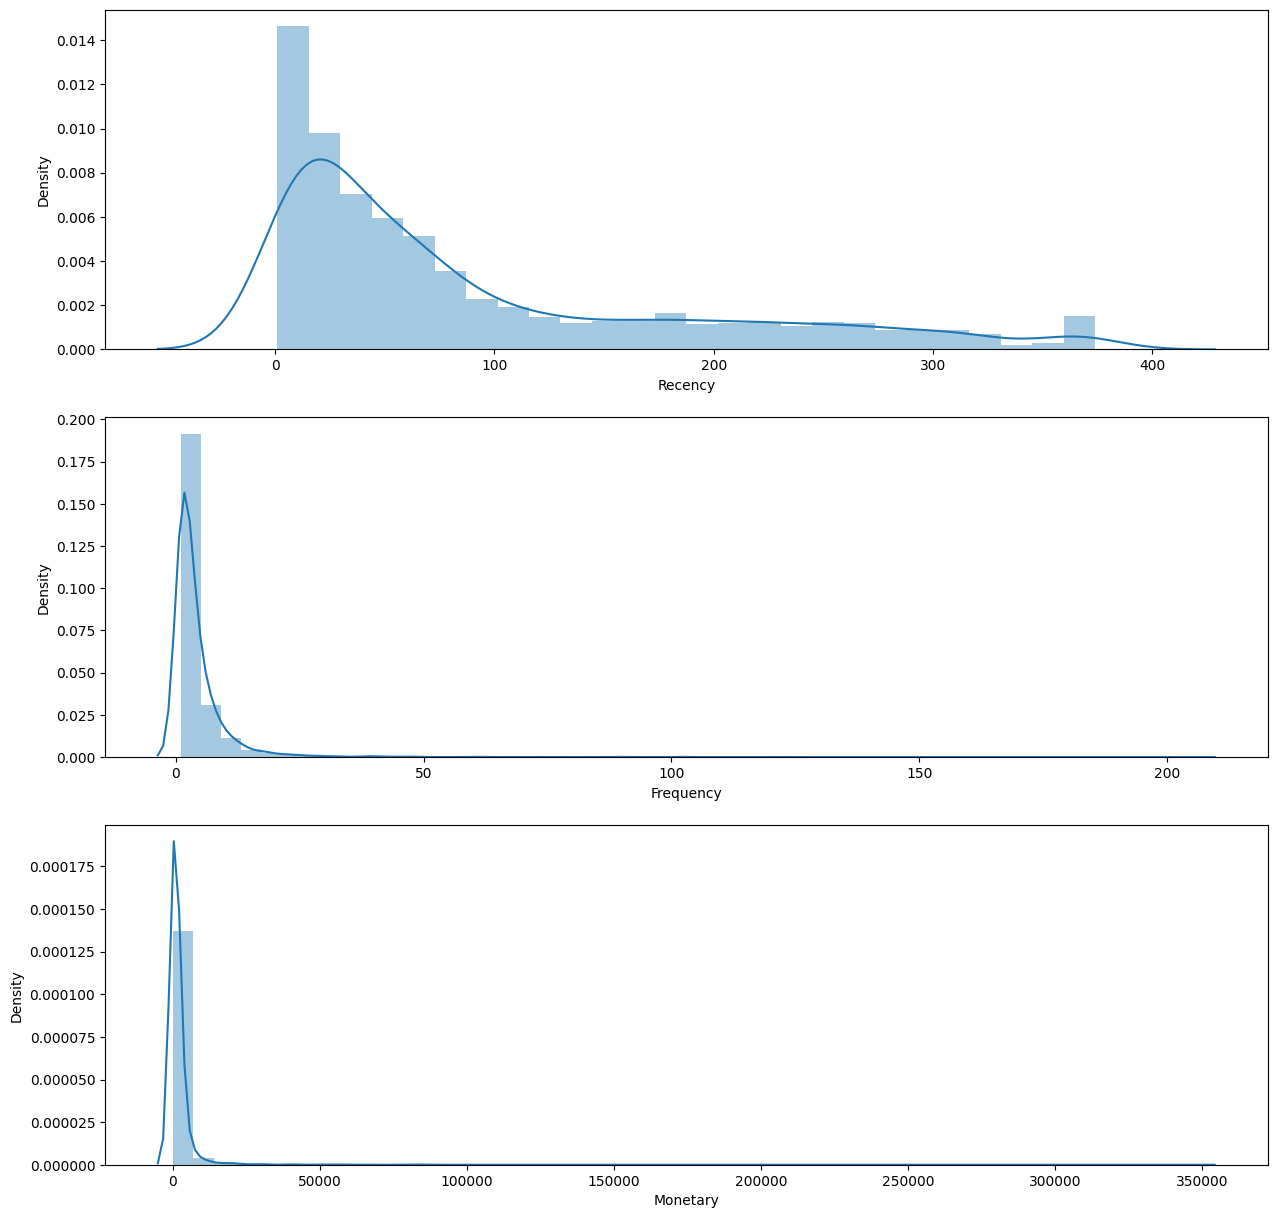

In [89]:
# Checking distribution of Recency, Frequency and Monetary columns
plt.figure(figsize=(15, 15))
for i, var in enumerate(['Recency', 'Frequency', 'Monetary'], 1):
    plt.subplot(3, 1, i)
    sns.distplot(rfm[var])

The above visual suggests that the variables are not normally distributed. Since clustering algorithms require the variables to be normally distributed, we can apply log transformation in order to achieve that.

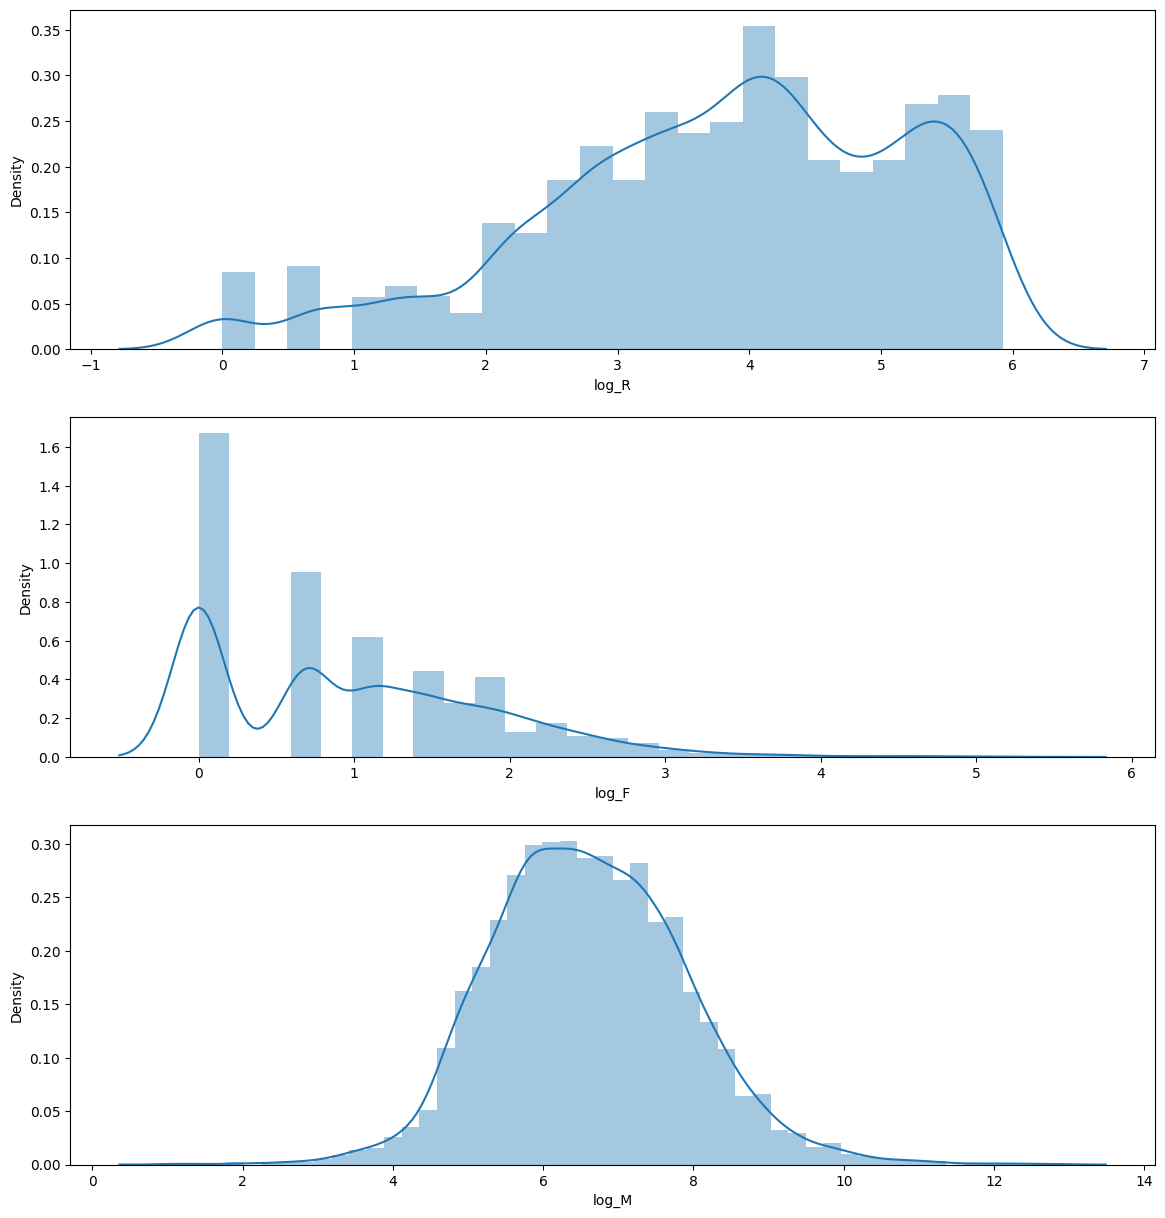

In [90]:
rfm["log_R"] = np.log(rfm['Recency'])
rfm["log_F"] = np.log(rfm['Frequency'])
rfm["log_M"] = np.log(rfm['Monetary'])

plt.figure(figsize=(14, 15))
for i, var in enumerate(['log_R', 'log_F', 'log_M'], 1):
    plt.subplot(3, 1, i)
    sns.distplot(rfm[var])

Now, we have to find the optimal "k" for our k-means clustering model

We have to one last step before making the model, which is **standardization**. If your variables are on different scales, those with larger scales will dominate the clustering results.

In [91]:
rfm_scaled = rfm[['log_R', 'log_F', 'log_M']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_scaled)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['log_R', 'log_F', 'log_M'])
rfm_scaled.head()

,log_R,log_F,log_M
0,0.942545,1.562935,-0.532891
1,-1.940934,-0.315366,0.452917
2,0.365552,-1.079079,-0.935873
3,-0.025067,0.131378,0.999531
4,-1.006034,-1.079079,-0.699690


## K-means Clustering

Now, we can start with our K-means cluster modelling. To start, we first need to find the optimum "k".

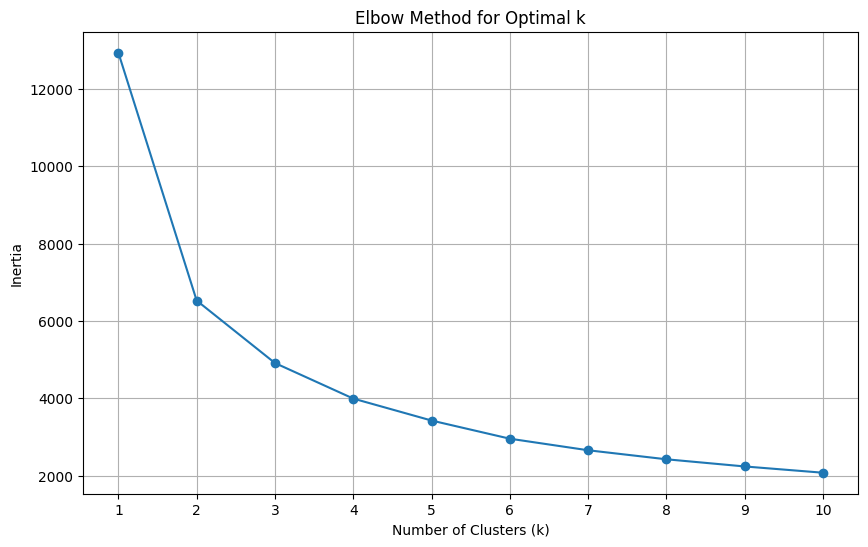

In [92]:
# Using elbow method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=100)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid()
plt.show()

In [93]:
# Using Silhouette score
silhouette_scores = []

for k in range(2, 11):  # Silhouette is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)

print('Silhouette scores for different k:')
for i, val in enumerate(silhouette_scores):
    print(i+1, " ", val)


Silhouette scores for different k:
1   0.4185944309659568
2   0.33701972941821834
3   0.3304827838611711
4   0.30862479998162196
5   0.3072532927616445
6   0.3089692941984912
7   0.3029048686996417
8   0.2805265662141025
9   0.28277214833671666


From both Silhouette and Elbow method, we can conclude that the **optimum value of k is 3**. Therefore, our model will contain 3 clusters. 

In [94]:
# KMeans clustering with k = 3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_score_sum,Segment,log_R,log_F,log_M,Cluster
Customer ID,,,,,,,,,,,,,
12346.0,165,11,372.86,1,4,1,141,6,Medium,5.105945,2.397895,5.921203,0
12347.0,3,2,1323.32,4,1,3,413,8,Medium,1.098612,0.693147,7.187899,0
12348.0,74,1,222.16,1,0,0,100,1,Low,4.304065,0.000000,5.403398,1
12349.0,43,3,2671.14,2,2,4,224,8,Medium,3.761200,1.098612,7.890261,0
12351.0,11,1,300.93,4,0,1,401,5,Medium,2.397895,0.000000,5.706878,1


In [95]:
# Mean RFM values for different clusters
rfm.groupby(['Cluster'])[['Recency', 'Frequency', 'Monetary']].mean().T

Cluster,0,1,2
Recency,63.967835,154.030131,13.332512
Frequency,3.678920,1.244457,13.077586
Monetary,1416.586619,306.929262,7133.088507


Now, we can analyze the clusters.

In [96]:
fig = px.scatter_3d(
    rfm,
    x='log_R',
    y='log_F',
    z='log_M',
    color='Cluster',
    title='Customer Segments',
    labels={'log_R': 'Recency', 'log_F': 'Frequency', 'log_M': 'Monetary'},
    opacity=0.7
)

# Size of the plot was small, therefore, increasing the size
fig.update_layout(
    width=1200,  # Width of the plot in pixels
    height=800,  # Height of the plot in pixels
    scene=dict(
        xaxis_title='Recency',
        yaxis_title='Frequency',
        zaxis_title='Monetary'
    )
)

fig.update_traces(marker=dict(size=5))

# Show the interactive plot
fig.show()

In the above plot, we can see that blue cluster (**Cluster 0**) represents medium value customers, red cluster (**Cluster 1**) represents low value customers, and yellow cluster (**Cluster 2**) represents high value customers.

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

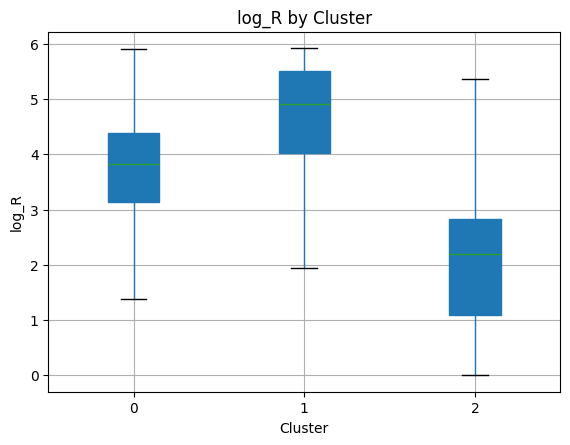

<Figure size 1000x600 with 0 Axes>

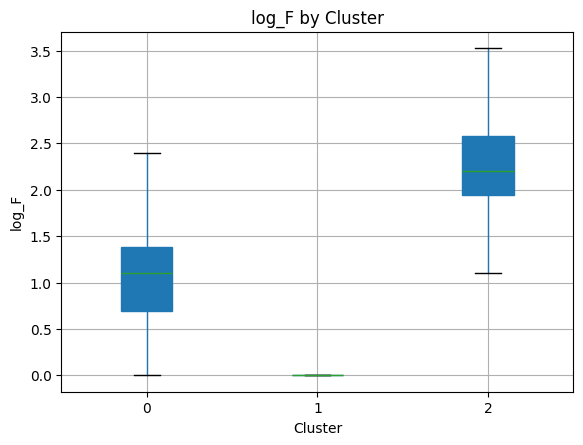

<Figure size 1000x600 with 0 Axes>

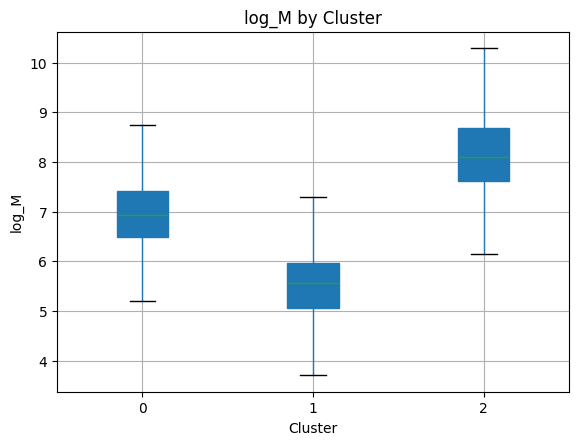

In [97]:
plt.figure(figsize = (10, 6))
for metric in ['log_R', 'log_F', 'log_M']:
    plt.figure(figsize=(10, 6))
    rfm.boxplot(column=metric, by='Cluster', patch_artist=True, showfliers=False)
    plt.title(f'{metric} by Cluster')
    plt.suptitle('')
    plt.xlabel('Cluster')
    plt.ylabel(metric)
    plt.show()

## Conclusion  

The project demonstrates that the customer segmentation analysis can be created through the data mining techniques and appropriate clustering model.  
- In the data exploration process, we were able to gain significant insights into the portion of the dataset which we did not use in customer segmentation, like returned and cancelled products.
- In the sales analysis over time, we uncovered the most and least profitable months and quarters, with overall sales trend over the fiscal year.  
- In the RFM analysis and clustering part, we were successfully able to cluster/segment people based on their RFM scores.


## Recommendation  
 
- **High value**: These customers should be extremely important to the company. Therefore, focus on retaining this group should be done. Exclusive deals and personalized offers can help.
- **Medium value**: These customers have low frequency and moderate recency, implying they need some personalized incentives to re-engage with the company.
- **Low value**: These customers have extremely low frequency, so targeted ads and discounts may prompt them to start buying products again.

## Dataset
- Chen, D. (2014). Online Retail II [UCI Machine Learning Repository]. https://archive.ics.uci.edu/ml/datasets/online+retail+II
  
## References
- Carneiro, F., Moreira, R. M. A., & Miguéis, V. (2021). Applying data mining techniques and analytic hierarchy process to the food industry: Estimating customer lifetime value. In Proceedings of the 2021 International Conference on Industrial Engineering and Operations Management (pp. 1-12). IEOM Society International. http://www.ieomsociety.org/brazil2020/papers/125.pdf
- Wei, J.-T., Lin, S.-Y., & Wu, H.-H. A review of the application of RFM model. (2010). ResearchGate. https://www.researchgate.net/publication/228399859_A_review_of_the_application_of_RFM_model